In [1]:
import os
import sys

ROOT_DIR = os.path.abspath("__file__" + "/../../")
sys.path.insert(0, f"{ROOT_DIR}")

In [2]:
from src.spinfoam.spinfoams import SingleVertexSpinFoam
from src.spinfoam.sf_env import SpinFoamEnvironment

spin_j = 3.0
env = SpinFoamEnvironment(
    spinfoam_model=SingleVertexSpinFoam(spin_j=spin_j)
)

In [3]:
import torch

from gfn import LogitPBEstimator, LogitPFEstimator, LogZEstimator
from gfn.losses import TBParametrization, TrajectoryBalance
from gfn.samplers import DiscreteActionsSampler, TrajectoriesSampler

logit_PF = LogitPFEstimator(env=env, module_name="NeuralNet")
logit_PB = LogitPBEstimator(
    env=env,
    module_name="NeuralNet",
    torso=logit_PF.module.torso,  # To share parameters between PF and PB
)
logZ = LogZEstimator(torch.tensor(0.0))


training_sampler = TrajectoriesSampler(
    env=env,
    actions_sampler=DiscreteActionsSampler(
        estimator=logit_PF,
        epsilon=0.5
    )
)

eval_sampler = TrajectoriesSampler(
    env=env, actions_sampler=DiscreteActionsSampler(estimator=logit_PF)
)

parametrization = TBParametrization(logit_PF, logit_PB, logZ)
loss_fn = TrajectoryBalance(
    parametrization=parametrization,
    log_reward_clip_min=-500.0
)

params = [
    {
        "params": [
            val for key, val in parametrization.parameters.items() if "logZ" not in key
        ],
        "lr": 0.001,
    },
#     {"params": [val for key, val in parametrization.parameters.items() if "logZ" in key], "lr": 0.1},
]
optimizer = torch.optim.Adam(params)

c:\Users\Jared\anaconda3\envs\torchgfn\lib\site-packages\torch\optim\adam.py:33: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super().__init__(params, defaults)


In [5]:
from tqdm import tqdm

losses = []
terminal_states = []

for i in (pbar := tqdm(range(int(1e3)))):
    trajectories = training_sampler.sample(
        n_trajectories=int(1e3)
    )
    optimizer.zero_grad()
    loss = loss_fn(trajectories)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        pbar.set_postfix({"loss": loss.item()})
        eval_trajectories = eval_sampler.sample(
            n_trajectories=int(1e3)
        )
        terminal_states.append(
            eval_trajectories.last_states.states_tensor[None, :, :]
        )
       
    losses.append(loss.item())

100%|██████████| 1000/1000 [04:24<00:00,  3.78it/s, loss=0.667]


In [6]:
intertwiners = torch.cat(terminal_states)
cos_angles = intertwiners*(intertwiners+1)/(2*spin_j*(spin_j+1)) - 1
ave_cos_angles = torch.mean(cos_angles, dim=1)
ave_cos_angles

tensor([[-0.8282, -0.8133, -0.8194, -0.8359, -0.8358],
        [-0.5446, -0.5926, -0.4540, -0.5617, -0.5504],
        [-0.5324, -0.6465, -0.3988, -0.6356, -0.5448],
        [-0.6644, -0.7676, -0.4538, -0.7614, -0.7424],
        [-0.7647, -0.7156, -0.5020, -0.8253, -0.7615],
        [-0.7587, -0.7178, -0.3490, -0.7913, -0.7792],
        [-0.6968, -0.6485, -0.3240, -0.7575, -0.7711],
        [-0.7177, -0.6302, -0.5149, -0.8118, -0.7617],
        [-0.7615, -0.7684, -0.3527, -0.7478, -0.7691],
        [-0.7412, -0.6839, -0.4322, -0.7648, -0.7714]])

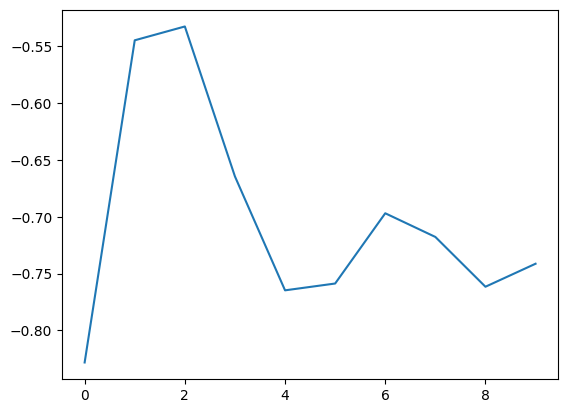

In [7]:
import matplotlib.pyplot as plt

plt.plot(ave_cos_angles[:, 0])